In [ ]:
# The Julia boostrap block
# This should be run for the first time to install Julia kernel, and then refresh this page (e.g., Ctrl-R)
# so that colab will redirect to the installed Julia kernel
# and then doing your own work

# 1. install latest Julia using jill.py
#    tip: one can install specific Julia version using e.g., `jill install 1.7`
!pip install jill && jill install --upstream Official --confirm
# 2. install IJulia kernel
! julia -e 'using Pkg; pkg"add IJulia, PyPlot"; using IJulia; installkernel("Julia")'
# 3. hot-fix patch to strip the version suffix of the installed kernel so that this notebook kernelspec is version agnostic
!jupyter kernelspec install $(jupyter kernelspec list | grep julia | tr -s ' ' | cut -d' ' -f3) --replace --name julia

     |████████████████████████████████| 41 kB 183 kB/s 
     |████████████████████████████████| 87 kB 5.3 MB/s 
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115942 sha256=3a5a3883b3298f9b21833d49551b465b573866e888cf4b253a8e6e6a1e1acdfe
  Stored in directory: /root/.cache/pip/wheels/8a/67/fb/2e8a12fa16661b9d5af1f654bd199366799740a85c64981226
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=d520321137d9e80d9ff3633331adccbd2d49d30f0a74849f5f181b59a7072f25
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built fire wget
JILL - Julia Installer 4 Linux (MacOS, Windows and FreeBSD) -- Light

querying release information from https://julialang-s3.julialang.org/bin/versions.json
----- Download Julia -----
downloading Julia release for 1.7.2-linux-x86_64
downloading from https://storage.googleapis.com/julialang2/bin/linux/x64/1.7/julia-1.7.2-linux-x86_64.tar.gz

finished

In [34]:
using PyPlot

function diffusion_1D(NX)
    # Nx = 41 ; # try changing this number from 41 to 81 and Run All ... what happens?
    dx = 2/(NX-1);
    NT = 20 ;   # NT is the number of timesteps we want to calculate
    nu = 0.3    # the value of viscosity
    sigma = 0.2 # sigma is a parameter, we'll learn more about it later
    dt = (sigma*(dx^2))/nu ; # dt is the amount of time each timestep covers (delta t)


    u = ones(Float64,NX);    # function ones()
    s = Int(floor(0.5/dx));
    e = Int(floor(1/dx));
    u[s:e] .= 2.0;
    un = ones(Float64,NX); # initialize a temporary array
    for n in 1:NT          # loop for values of n from 0 to nt, so it will run nt times
        un = copy(u)       # copy the existing values of u into un
        for i in 2:NX-1    # you can try commenting this line and...
            u[i] = un[i] + nu*dt/dx^2 * ( un[i+1] - 2*un[i] + un[i-1] );
        end
    end
    plot(range(0, length = NX ,stop = 2),u);
end

diffusion_1D (generic function with 1 method)

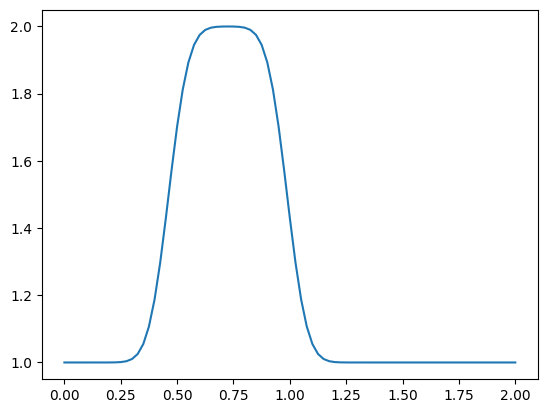

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f8ee62d6790>

In [35]:
diffusion_1D(81)

In [36]:
using LinearAlgebra
function diffusion_1D_implicit(NX)
    # Nx = 41 ; # try changing this number from 41 to 81 and Run All ... what happens?
    dx = 2/(NX-1);
    NT = 20 ;   # NT is the number of timesteps we want to calculate
    nu = 0.3    # the value of viscosity
    sigma = 0.2 # sigma is a parameter, we'll learn more about it later
    dt = (sigma*(dx^2))/nu ; # dt is the amount of time each timestep covers (delta t)


    u = ones(Float64,NX);    # function ones()
    s = Int(floor(0.5/dx));
    e = Int(floor(1/dx));
    u[s:e] .= 2.0;
    un = ones(Float64,NX); # initialize a temporary array

    # initialize a matrix
    # diagm is the function to build diagonal matrix in std lib LinearAlgebra
    # >diagm([1,2])
    #  2×2 Matrix{Int64}:
    #     1   0
    #     0   2
    A = diagm(ones(Float64,NX));

    for row in 2:NX-1
        A[row,row-1] = -nu*dt/dx^2
        A[row,row] = 2*nu*dt/dx^2 + 1
        A[row,row+1] =  -nu*dt/dx^2
        # (u[i] - un[i])/dt = nu/dx^2 * (u[i+1] - 2*u[i] + u[i-1]);
        # then we have:
        # u[i] - nu*dt/dx^2 * (u[i+1] - 2*u[i] + u[i-1]) = un[i];
        # Au = un
    end

    for n in 1:NT          # loop for values of n from 0 to nt, so it will run nt times
        un = copy(u)       # copy the existing values of u into un
        u = A \ un         # solve linear equation, Ax=b, solve x by x = A \ b
    end
    plot(range(0, length = NX ,stop = 2),u);
end

diffusion_1D_implicit (generic function with 1 method)

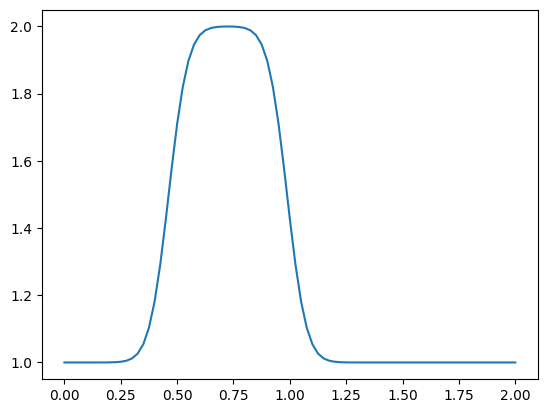

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f8ee36d94d0>

In [37]:
diffusion_1D_implicit(81)

$$
∂_t u = \nu Δu \\
\dfrac{u^{n+1}_i - u^n_i}{dt} = \dfrac{\nu}{dx^2} ( \theta (u^{n+1}_{i+1} - 2u^{n+1}_i + u^{n+1}_{i-1}) + (1-\theta) (u^{n}_{i+1} - 2u^{n}_i + u^{n}_{i-1})) \\
u^{n+1}_{i} - \dfrac{\nu dt}{dx^2} \theta (u^{n+1}_{i+1} - 2u^{n+1}_i + u^{n+1}_{i-1}) = u^n_i + \dfrac{\nu dt}{dx^2} (1-\theta) (u^{n}_{i+1} - 2u^{n}_i + u^{n}_{i-1})
$$

$$
\mathrm{AU}=\left[\begin{array}{ccccc}
1 & 0 & & & \\
-\dfrac{\nu dt}{dx^2} \theta & 2\dfrac{\nu dt}{dx^2} \theta+1 & -\dfrac{\nu dt}{dx^2} \theta & & \\
& \ddots & \ddots & \ddots & \\
& & -\dfrac{\nu dt}{dx^2} \theta & 2\dfrac{\nu dt}{dx^2} \theta+1 & -\dfrac{\nu dt}{dx^2} \theta \\
& & & 0 & 1
\end{array}\right]\left[\begin{array}{c}
\mathrm{u}_{1} \\
\mathrm{u}_{2} \\
\vdots \\
\mathrm{u}_{\mathrm{J}-1} \\
\mathrm{u}_{\mathrm{J}}
\end{array}\right]
$$

In [38]:
function diffusion_1D_theta(NX,theta;sigma=0.2)
    # Nx = 41 ; # try changing this number from 41 to 81 and Run All ... what happens?
    dx = 2/(NX-1);
    NT = 20 ;   # NT is the number of timesteps we want to calculate
    nu = 0.3    # the value of viscosity
    sigma = sigma # sigma is a parameter, we'll learn more about it later
    dt = (sigma*(dx^2))/nu ; # dt is the amount of time each timestep covers (delta t)


    u = ones(Float64,NX);    # function ones()
    s = Int(floor(0.5/dx));
    e = Int(floor(1/dx));
    u[s:e] .= 2.0;
    un = ones(Float64,NX); # initialize a temporary array
   
    A = diagm(ones(Float64,NX)); # initialize a matrix
    for row in 2:NX-1
        A[row,row-1] = -theta*nu*dt/dx^2
        A[row,row] = 2*theta*nu*dt/dx^2 + 1
        A[row,row+1] =  -theta*nu*dt/dx^2
        # (u[i] - un[i])/dt = nu/(dx^2) * (theta*(u[i+1] - 2*u[i] + u[i-1]) + (1-theta)*(un[i+1] - 2*un[i] + un[i-1]));
        # then we have:
        # u[i] - nu*dt/(dx^2) * theta*(u[i+1] - 2*u[i] + u[i-1]) = un[i] + nu*dt/(dx^2)(1-theta)*(un[i+1] - 2*un[i] + un[i-1]);
    end

    B = diagm(ones(Float64,NX)); # initialize a matrix
    for row in 2:NX-1
        B[row,row-1] = (1-theta)*nu*dt/dx^2
        B[row,row] = -2*(1-theta)*nu*dt/dx^2 + 1
        B[row,row+1] =  (1-theta)*nu*dt/dx^2
        # (u[i] - un[i])/dt = nu/(dx^2) * (theta*(u[i+1] - 2*u[i] + u[i-1]) + (1-theta)*(un[i+1] - 2*un[i] + un[i-1]));
        # then we have:
        # u[i] - nu*dt/(dx^2) * theta*(u[i+1] - 2*u[i] + u[i-1]) = un[i] + nu*dt/(dx^2)(1-theta)*(un[i+1] - 2*un[i] + un[i-1]);
    end

    for n in 1:NT          # loop for values of n from 0 to nt, so it will run nt times
        un = copy(u)       # copy the existing values of u into un
        u = A \ (B*un)         # solve linear equation
    end
    plot(range(0, length = NX ,stop = 2),u);
end

diffusion_1D_theta (generic function with 1 method)

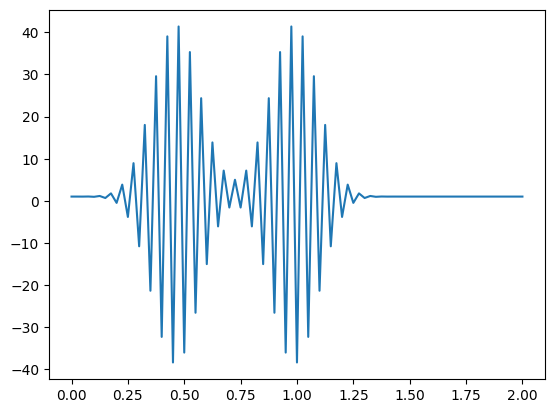

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f8ee3558dd0>

In [39]:
diffusion_1D_theta(81, 0;sigma=0.6) # explicit

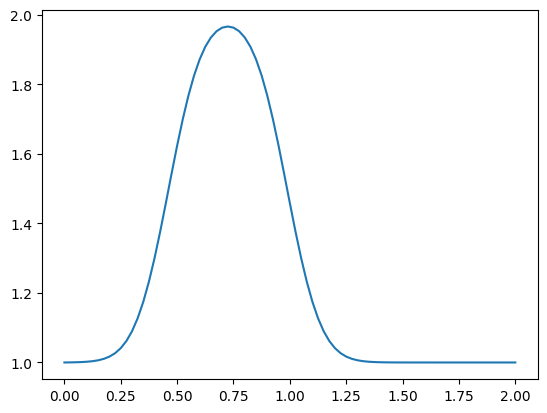

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f8ee34e3290>

In [40]:
diffusion_1D_theta(81, 1;sigma=0.6) # implicit

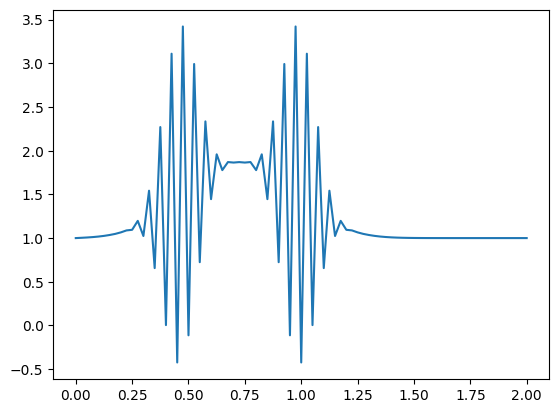

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f8ee2fccdd0>

In [57]:
diffusion_1D_theta(81, 1/4;sigma=1.2) # theta method

In [55]:
using SparseArrays
NX = 10
theta = 1
nu = 0.3
dx = 2 / (NX - 1)
dt = (0.2*(dx^2))/nu
A = diagm(ones(Float64,NX)); # initialize a matrix
A = zeros(NX,NX)
for row in 2:NX-1
    A[row,row-1] = -theta*nu*dt/dx^2
    A[row,row] = 2*theta*nu*dt/dx^2 + 1
    A[row,row+1] =  -theta*nu*dt/dx^2
end
sparse(A)

10×10 SparseMatrixCSC{Float64, Int64} with 24 stored entries:
   ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
 -0.2   1.4  -0.2    ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
   ⋅   -0.2   1.4  -0.2    ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
   ⋅     ⋅   -0.2   1.4  -0.2    ⋅     ⋅     ⋅     ⋅     ⋅ 
   ⋅     ⋅     ⋅   -0.2   1.4  -0.2    ⋅     ⋅     ⋅     ⋅ 
   ⋅     ⋅     ⋅     ⋅   -0.2   1.4  -0.2    ⋅     ⋅     ⋅ 
   ⋅     ⋅     ⋅     ⋅     ⋅   -0.2   1.4  -0.2    ⋅     ⋅ 
   ⋅     ⋅     ⋅     ⋅     ⋅     ⋅   -0.2   1.4  -0.2    ⋅ 
   ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅   -0.2   1.4  -0.2
   ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 

In [43]:
A = spdiagm(0 => fill(2*theta*nu*dt/dx^2+1,NX),
          -1 => fill(-theta*nu*dt/dx^2,NX-1),
           1 => fill(-theta*nu*dt/dx^2,NX-1))

10×10 SparseMatrixCSC{Float64, Int64} with 28 stored entries:
  1.4  -0.2    ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
 -0.2   1.4  -0.2    ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
   ⋅   -0.2   1.4  -0.2    ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
   ⋅     ⋅   -0.2   1.4  -0.2    ⋅     ⋅     ⋅     ⋅     ⋅ 
   ⋅     ⋅     ⋅   -0.2   1.4  -0.2    ⋅     ⋅     ⋅     ⋅ 
   ⋅     ⋅     ⋅     ⋅   -0.2   1.4  -0.2    ⋅     ⋅     ⋅ 
   ⋅     ⋅     ⋅     ⋅     ⋅   -0.2   1.4  -0.2    ⋅     ⋅ 
   ⋅     ⋅     ⋅     ⋅     ⋅     ⋅   -0.2   1.4  -0.2    ⋅ 
   ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅   -0.2   1.4  -0.2
   ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅   -0.2   1.4

In [44]:
A[1,1] = 1
A[1,2] = 0
A[NX, NX] = 1
A[NX, NX-1] = 0
A

10×10 SparseMatrixCSC{Float64, Int64} with 28 stored entries:
  1.0   0.0    ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
 -0.2   1.4  -0.2    ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
   ⋅   -0.2   1.4  -0.2    ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
   ⋅     ⋅   -0.2   1.4  -0.2    ⋅     ⋅     ⋅     ⋅     ⋅ 
   ⋅     ⋅     ⋅   -0.2   1.4  -0.2    ⋅     ⋅     ⋅     ⋅ 
   ⋅     ⋅     ⋅     ⋅   -0.2   1.4  -0.2    ⋅     ⋅     ⋅ 
   ⋅     ⋅     ⋅     ⋅     ⋅   -0.2   1.4  -0.2    ⋅     ⋅ 
   ⋅     ⋅     ⋅     ⋅     ⋅     ⋅   -0.2   1.4  -0.2    ⋅ 
   ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅   -0.2   1.4  -0.2
   ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅    0.0   1.0

In [45]:
# Solving Large Sparse Linear Systems
# AU = B

# U = A \ B 
# using LU or QR factorization

# when A is large, maybe we need some iterative method, like gmres, cg
# check https://nextjournal.com/sosiris-de/pde-2018 for more details
